# Tablet method
The study is focus on tablet method for both discrete and continuous approach.  The discrete approach start with long-short term arguements inspired by MACD

In [42]:
import gc
gc.collect()

1517

In [30]:
import pandas as pd
import datetime as dt
import pytz
from sqlalchemy import create_engine
from tqdm import tqdm
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define your connection parameters
username = 'bullionbear'
password = 'Sunshine4Jellybean'
host = 'localhost'
port = '5432'
database = 'lynkoraDB'

# Create the connection string
connection_string = f'postgresql://{username}:{password}@{host}:{port}/{database}'

# Create the database engine
engine = create_engine(connection_string)

# Define your SQL query
n_days = 720
end_time = int(dt.datetime(2024, 5, 25, tzinfo=pytz.UTC).timestamp() * 1000) - 1
start_time = end_time - n_days * 86400_000
table = "btcusdt_kline_1s"
query = f'SELECT open_time, open, high, low, close, close_time FROM {table} where open_time between {start_time} and {end_time} order by open_time asc'

# Read the data in chunks
chunksize = 86400  # Adjust the chunk size as needed
data_frames = []

with tqdm(total=n_days, desc="Processing Chunks") as pbar:
    for chunk in pd.read_sql_query(query, engine, chunksize=chunksize):
        # Process each chunk here (e.g., filter, transform, etc.)
        grouped = chunk.groupby(chunk.index // 3600).agg(
            open_time=('open_time', 'first'),
            open=('open', 'first'),
            high=('high', 'max'),
            low=('low', 'min'),
            close=('close', 'last'),
            close_time=('close_time', 'last'),
        )
        data_frames.append(grouped)
        pbar.update(1)  # Update the progress bar
    

# Combine all chunks into a single DataFrame if needed
raw = pd.concat(data_frames, ignore_index=True)

raw.head()

Processing Chunks: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 720/720 [05:11<00:00,  2.31it/s]


,open_time,open,high,low,close,close_time
0,1654387200000,29864.03,29897.18,29729.37,29740.64,1654390799999
1,1654390800000,29740.64,29755.23,29681.85,29691.74,1654394399999
2,1654394400000,29691.73,29799.99,29678.50,29793.99,1654397999999
3,1654398000000,29793.99,29819.95,29748.88,29766.95,1654401599999
4,1654401600000,29766.95,29782.19,29686.00,29722.90,1654405199999


In [43]:
raw.tail()

,open_time,open,high,low,close,close_time
17274,1716578382000,68963.75,69250.00,68848.41,68949.99,1716581981999
17275,1716581982000,68950.00,69022.12,68807.14,68924.11,1716585581999
17276,1716585582000,68924.12,68944.68,68753.55,68772.00,1716589181999
17277,1716589182000,68771.99,68824.81,68674.39,68711.55,1716592781999
17278,1716592782000,68711.55,68726.15,68524.94,68549.99,1716595199999


In [31]:
df = raw.copy()
df['date'] = pd.to_datetime(df['open_time'], unit='ms')
df.set_index('date', inplace=True)
df.head()

,open_time,open,high,low,close,close_time
date,,,,,,
2022-06-05 00:00:00,1654387200000,29864.03,29897.18,29729.37,29740.64,1654390799999
2022-06-05 01:00:00,1654390800000,29740.64,29755.23,29681.85,29691.74,1654394399999
2022-06-05 02:00:00,1654394400000,29691.73,29799.99,29678.50,29793.99,1654397999999
2022-06-05 03:00:00,1654398000000,29793.99,29819.95,29748.88,29766.95,1654401599999
2022-06-05 04:00:00,1654401600000,29766.95,29782.19,29686.00,29722.90,1654405199999


In [44]:
df.tail()

,open_time,open,high,low,close,close_time,log_price,log_return,ma5_return
date,,,,,,,,,
2024-05-24 19:19:42,1716578382000,68963.75,69250.00,68848.41,68949.99,1716581981999,11.141137,-0.000200,0.001776
2024-05-24 20:19:42,1716581982000,68950.00,69022.12,68807.14,68924.11,1716585581999,11.140761,-0.000375,0.002167
2024-05-24 21:19:42,1716585582000,68924.12,68944.68,68753.55,68772.00,1716589181999,11.138552,-0.002209,0.000622
2024-05-24 22:19:42,1716589182000,68771.99,68824.81,68674.39,68711.55,1716592781999,11.137673,-0.000879,-0.001372
2024-05-24 23:19:42,1716592782000,68711.55,68726.15,68524.94,68549.99,1716595199999,11.135319,-0.002354,-0.001204


In [36]:
import numpy as np
df.loc[:, 'log_price'] = np.log(df.loc[:, 'close'])
df.loc[:, 'log_return'] = df.loc[:, 'log_price'].diff()
df.loc[:, 'ma5_return'] = df.loc[:, 'log_return'].rolling(window=5).mean()

In [37]:
mean, std

(5.1655612974405716e-05, 0.005374249849323545)

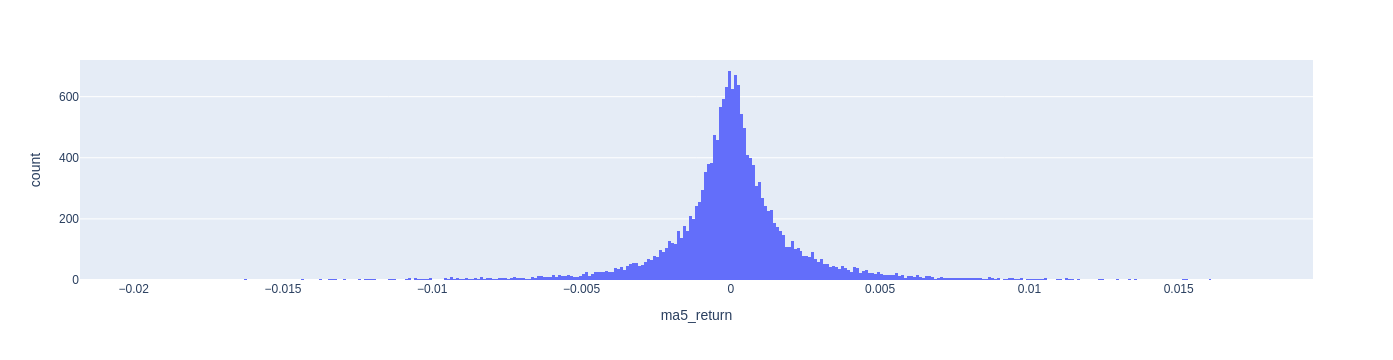

In [39]:
import pandas as pd
import plotly.express as px

# Create a sample DataFrame

# Create a histogram
fig = px.histogram(df, 'ma5_return')

# Show the plot
fig.show()

In [41]:
import plotly.graph_objects as go

# Assuming trial_performance['training'] and trial_performance['testing']
# are your data dictionaries for training and testing performance respectively
training_df = pd.DataFrame(trial_performance['training'])
testing_df = pd.DataFrame(trial_performance['testing'])

# Reset index to ensure alignment for comparison, if necessary
training_df.reset_index(drop=True, inplace=True)
testing_df.reset_index(drop=True, inplace=True)

# Create traces for training and testing returns
trace1 = go.Scatter(
    x=training_df.index,
    y=training_df['target'],
    mode='lines+markers',
    name='Training Return',
    marker=dict(color='blue')
)

trace2 = go.Scatter(
    x=testing_df.index,
    y=testing_df['target'],
    mode='lines+markers',
    name='Testing Return',
    marker=dict(color='red')
)

# Define the layout
layout = go.Layout(
    title='Training vs. Testing Target Over Trials',
    xaxis=dict(title='Trial Number'),
    yaxis=dict(title='Target'),
    hovermode='closest'
)

# Create the figure and add traces
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show the figure
fig.show()


,open_time,open,high,low,close,close_time,log_price,log_return,ma5_return
date,,,,,,,,,
2024-05-24 19:19:42,1716578382000,68963.75,69250.00,68848.41,68949.99,1716581981999,11.141137,-0.000200,0.001776
2024-05-24 20:19:42,1716581982000,68950.00,69022.12,68807.14,68924.11,1716585581999,11.140761,-0.000375,0.002167
2024-05-24 21:19:42,1716585582000,68924.12,68944.68,68753.55,68772.00,1716589181999,11.138552,-0.002209,0.000622
2024-05-24 22:19:42,1716589182000,68771.99,68824.81,68674.39,68711.55,1716592781999,11.137673,-0.000879,-0.001372
2024-05-24 23:19:42,1716592782000,68711.55,68726.15,68524.94,68549.99,1716595199999,11.135319,-0.002354,-0.001204
